In [1]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
directory = "../input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations"
image_directory = "../input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images"
df = pd.read_csv("../input/face-mask-detection-dataset/train.csv")
df_test = pd.read_csv("../input/face-mask-detection-dataset/submission.csv")

Using TensorFlow backend.


In [2]:
cvNet = cv2.dnn.readNetFromCaffe('../input/caffe-face-detector-opencv-pretrained-model/architecture.txt','../input/caffe-face-detector-opencv-pretrained-model/weights.caffemodel')

In [3]:
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)

In [4]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [5]:
jsonfiles= []
for i in tqdm(os.listdir(directory)):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

100%|██████████| 4326/4326 [00:07<00:00, 562.79it/s]


{'FileName': '3758.png',
 'NumOfAnno': 2,
 'Annotations': [{'isProtected': False,
   'ID': 217843115901993120,
   'BoundingBox': [112, 4, 455, 441],
   'classname': 'face_with_mask',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 12530598208497002,
   'BoundingBox': [113, 237, 345, 440],
   'classname': 'mask_colorful',
   'Confidence': 1,
   'Attributes': {}}]}

In [6]:
df = pd.read_csv("../input/face-mask-detection-dataset/train.csv")
df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [7]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in tqdm(df["name"].unique()):
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            data.append([img,labels["without mask"]])
random.shuffle(data)    

100%|██████████| 4326/4326 [01:54<00:00, 37.81it/s]


In [8]:
len(data)

5749

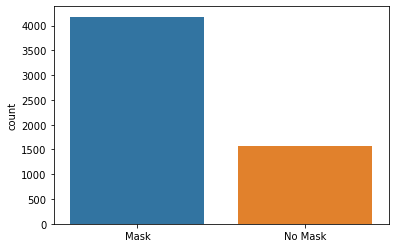

In [9]:
p = []
for face in data:
    if(face[1] == 0):
        p.append("Mask")
    else:
        p.append("No Mask")
sns.countplot(p)

In [10]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)


In [11]:
X[0].shape

(124, 124, 3)

In [12]:
X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

In [13]:
np.unique(Y)

array([0, 1])

In [14]:
Y.shape

(5749,)

In [15]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 124, 124, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 122, 122, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 120, 120, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 460800)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 460800)           

In [17]:
model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])

In [18]:
xtrain,xval,ytrain,yval=train_test_split(X, Y,train_size=0.8,random_state=0)

In [19]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(xtrain)

In [20]:
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32,
                    epochs=5,
                    verbose=1,
                    validation_data=(xval, yval))

Epoch 1/5
143/143 [==============================] - 21s 144ms/step - loss: 0.5293 - accuracy: 0.7366 - val_loss: 0.3029 - val_accuracy: 0.8565
Epoch 2/5
143/143 [==============================] - 20s 138ms/step - loss: 0.3129 - accuracy: 0.8601 - val_loss: 0.2342 - val_accuracy: 0.9130
Epoch 3/5
143/143 [==============================] - 19s 133ms/step - loss: 0.2939 - accuracy: 0.8783 - val_loss: 0.2170 - val_accuracy: 0.9165
Epoch 4/5
143/143 [==============================] - 20s 137ms/step - loss: 0.2864 - accuracy: 0.8831 - val_loss: 0.2819 - val_accuracy: 0.9035
Epoch 5/5
143/143 [==============================] - 19s 135ms/step - loss: 0.2724 - accuracy: 0.8914 - val_loss: 0.2092 - val_accuracy: 0.9235


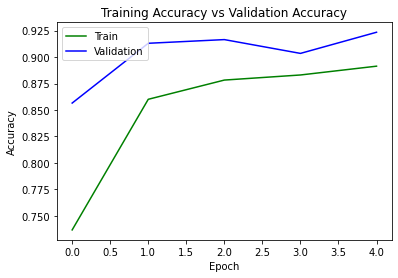

In [21]:
plt.plot(history.history['accuracy'],'g')
plt.plot(history.history['val_accuracy'],'b')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

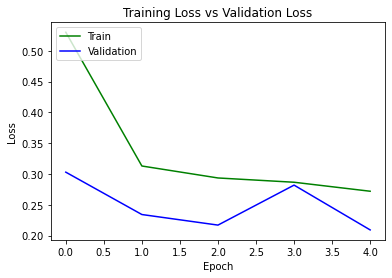

In [22]:
plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'b')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [23]:
print(len(df_test["name"]),len(df_test["name"].unique()))

8142 1698


In [24]:
test_images = ['1114.png','1504.jpg', '0072.jpg','0353.jpg','1374.jpg']

5it [00:00,  5.43it/s]


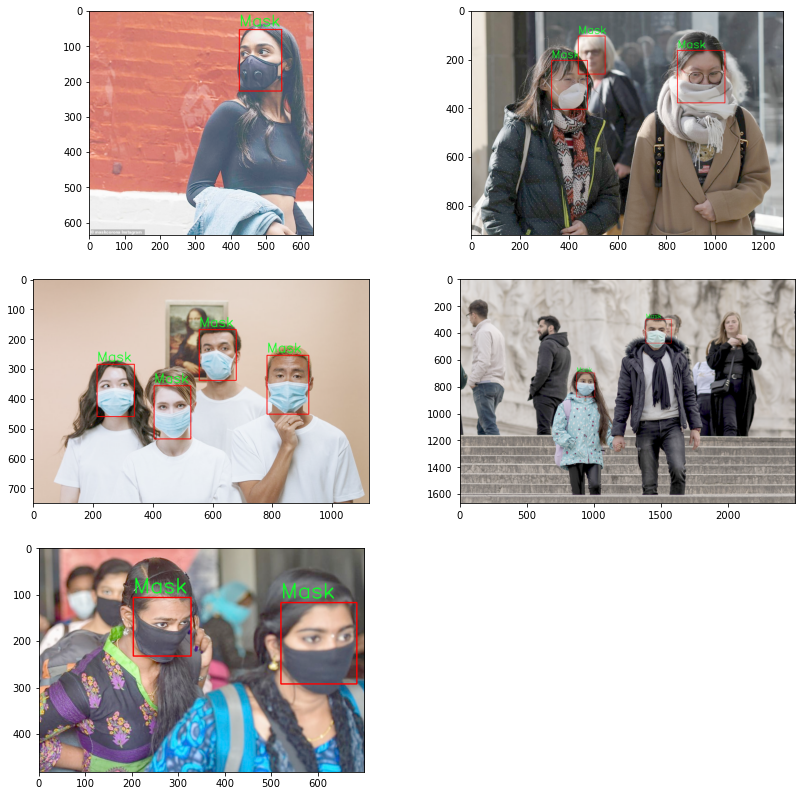

In [25]:
gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in tqdm(enumerate(test_images)):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()